In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3

%matplotlib inline

C:\Users\matt\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%%time
DATA_DIR = "../data/"

with open(DATA_DIR + "train.json") as train, open(DATA_DIR + "test.json") as test, open(DATA_DIR + "validation.json") as validation:
    train_json = json.load(train)
    test_json = json.load(test)
    validation_json = json.load(validation)

def set_image_filename(row, image_set):
    """
    Function that returns properly annotated image filename path from dataframe row
    Format: id_{imageId}_labels_{labelId}
    """
    labels = [int(x) for x in row['labelId']]
    true_image_path = DATA_DIR + "{}/id_{}_labels_{}.jpg".format(image_set, row['imageId'], labels)
    return true_image_path
    
def load_images(json_file, image_set):
    """
    Function to load, merge and correctly path all images for a given set
    Returns: dataframe
    """
    images_df = pd.DataFrame(json_file['images'])
    if image_set == 'test':
        images_df['imagePath'] = images_df['imageId'].map(lambda x: DATA_DIR + "{}/{}.jpg".format(image_set, x))
        return images_df
    else:
        annotations_df = pd.DataFrame(json_file['annotations'])
        merged = pd.merge(images_df, annotations_df, on='imageId', how='inner')
        merged['imagePath'] = merged.apply(lambda row: set_image_filename(row, image_set), axis=1)
        return merged
        
train_df = load_images(train_json, "train")
test_df = load_images(test_json, "test")
validation_df = load_images(validation_json, "validation")

Wall time: 24.2 s


In [3]:
%%time

SIZE = 224

def import_image(filepath, target_size=(SIZE, SIZE)):
    """
    Function to import images with a consistent size
    """    
    # img = Image.open(filename).convert("LA").resize((SIZE,SIZE))
    # return np.array(img)[:,:,0]
    img = load_img(filepath, target_size=target_size)
    return img_to_array(img)

# train_images = np.array([import_image(img) for img in train_df['imagePath']])
# test_images = np.array([import_image(img) for img in test_df['imagePath']])
# validation_images = np.array([import_image(img) for img in validation_df['imagePath']])

Wall time: 0 ns


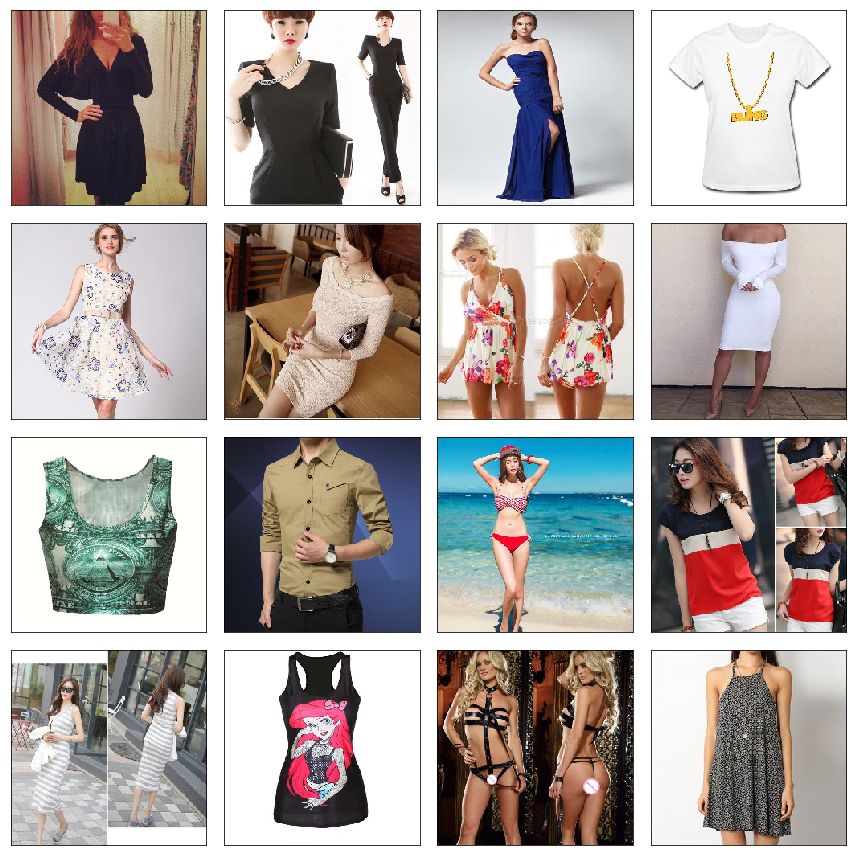

In [32]:
def plot_images(images_arr, n_images=4):
    fig, axes = plt.subplots(n_images, n_images, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img / 255.0)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()
    plt.show()
    
plot_images(validation_images)

In [4]:
def get_label_count(data):
    annotations = []
    if 'annotations' in data:
        for i in data['annotations']:
            annotations.extend(i['labelId'])
    return len(set(annotations))

TRAIN_LABELS = get_label_count(train_json)
VALIDATION_LABELS = get_label_count(validation_json)
print(TRAIN_LABELS)
print(VALIDATION_LABELS)

228
225


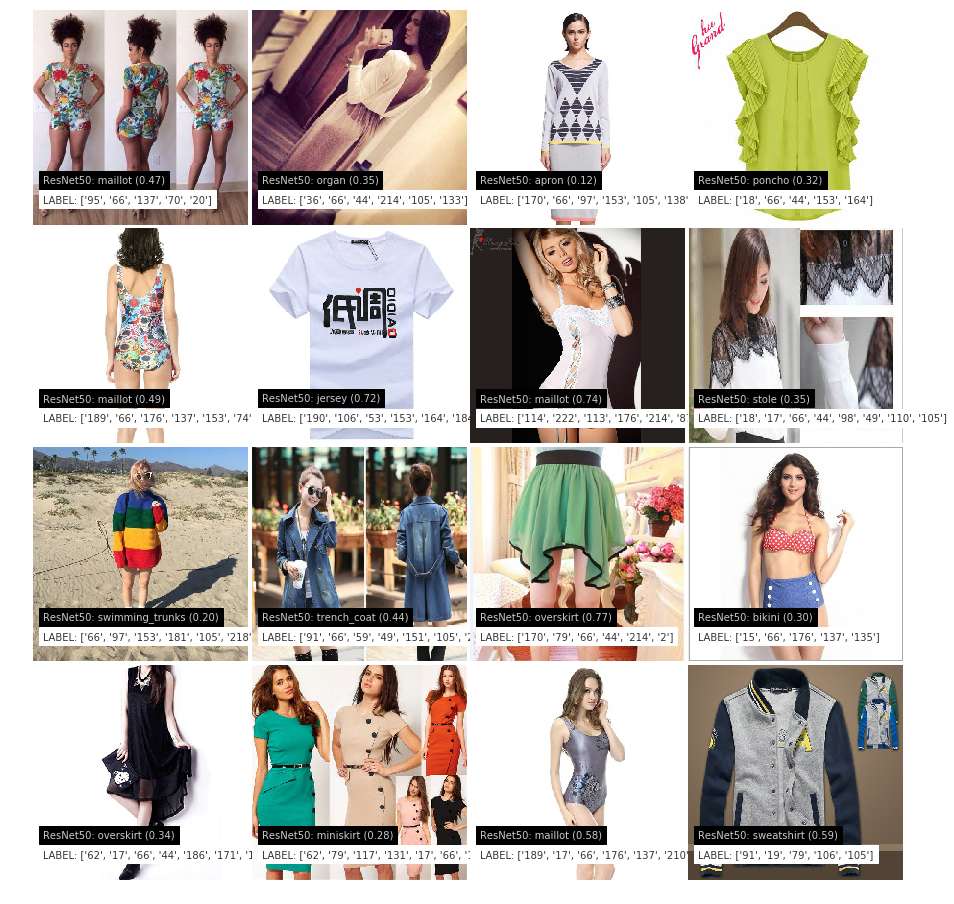

In [21]:
INPUT_SIZE = 224
NUM_CLASSES = 16
SEED = 101

subset = train_df[:NUM_CLASSES]

model = ResNet50(weights='imagenet')
j = int(np.sqrt(NUM_CLASSES))
i = int(np.ceil(1. * NUM_CLASSES / j))
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.05)

for i, (img_path, labels) in enumerate(subset[['imagePath', 'labelId']].values):
    ax = grid[i]
    img = import_image(img_path)
    ax.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    preds = model.predict(x)
    _, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]
    ax.text(10, 180, 'ResNet50: %s (%.2f)' % (imagenet_class_name , prob), color='w', backgroundcolor='k', alpha=0.8)
    ax.text(10, 200, 'LABEL: %s' % labels, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
plt.show()